## $\Rightarrow$ In this notebook, we shall describe how to calculate the 'MAP' values from the posterior samples obtained from the LIGO Result and then use them as the values for our injection parameters

<br>

In [1]:
# import modules

import json
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import h5py


from pycbc.waveform.generator import FDomainDetFrameGenerator, FDomainCBCGenerator
from pycbc.types.frequencyseries import load_frequencyseries
from pycbc import noise
from pycbc.waveform import get_fd_waveform
import pycbc
from pycbc.catalog import Merger

from pycbc.cosmology import redshift
from pycbc.cosmology import cosmological_quantity_from_redshift

### Link : 1) https://gwosc.org/eventapi/html/GWTC-2.1-confident/GW190425/v3/ (source file) 
### Link : 2) https://zenodo.org/record/6513631 ( here we find the same source file as in (1) )

#### $\Rightarrow$ LIGO DCC Link : https://dcc.ligo.org/P2000026/public (Not used here)

## Data Extraction

In [2]:
# open the hdf file

with h5py.File('IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_cosmo.h5', 'r') as f:
    
    print(f.keys(), '\n')
    print(f['C01:IMRPhenomPv2_NRTidal:LowSpin'].keys(), '\n')
    post_samples = np.array(f['C01:IMRPhenomPv2_NRTidal:LowSpin']['posterior_samples'])

<KeysViewHDF5 ['C01:IMRPhenomPv2_NRTidal:HighSpin', 'C01:IMRPhenomPv2_NRTidal:LowSpin', 'history', 'version']> 

<KeysViewHDF5 ['approximant', 'calibration_envelope', 'config_file', 'description', 'injection_data', 'meta_data', 'posterior_samples', 'priors', 'psds', 'skymap', 'version']> 



In [3]:
post_samples

array([(1.48704906, 0.94591187, 0.03879801, 0.01445153, 0.46715847, 0.82319839, 0.12218615, 5.69887987, 1038.51289424,  359.34438014, 0.2057698 , 0.98225212, 0.88021638, 1.2402155e+09, 2.00903151, 2.21689825, 1.2402155e+09, -0.01742842, -0.01435072, -0.04424732,  1.18276860e-02, -0.02120465,  0.00125778, -0.00283355, -0.0003558 , 0.00013035,  0.01351555,  1.31230813e-02,  0.05112762, -0.01313747, -0.01920955,  0.00422208,  0.00393975, -0.00050684, 0.01258788,  0.03714592, 0.06977049, -0.04136717, 0.0065166 , -0.03918655,  0.0379661 ,  0.03524956,  0.0312949 ,  0.04204219,  0.08486375, -0.01203834,  0.05234621,  0.01733629, -0.01609446,  0.00356841, -0.01627477,  0.02894214, -0.06361752, -0.00152126,  0.03006716,  0.0138203 ,  0.08016612, 240.18757054, 19.3984375, 32.55420588, 54.63204552, 91.68278927, 153.86086624, 258.20730749, 433.32015003, 727.19224813, 1220.36458658, 2048., 19.3984375, 32.55420588, 54.63204552, 91.68278927, 153.86086624, 258.20730749, 433.32015003, 727.19224813, 12

In [12]:
post_samples['mass_ratio'].max()

0.9999990598816111

### $\Rightarrow$ Extracting the posterior sample array for relevant parameters:

In [4]:
#-- time of coalescence --

event = 'GW190425'
merger = Merger(event, source='gwtc-2')

trigTime = merger.time
trigTime

1240215503.0

In [5]:
m1_det = post_samples['mass_1']    # Detector frame mass_1
m2_det = post_samples['mass_2']    # Detector frame mass_2

s1z = post_samples['spin_1z']      # spin_1z
s2z = post_samples['spin_2z']      # spin_2z

ra = post_samples['ra']            # right ascension
dec = post_samples['dec']          # declination

dL = post_samples['luminosity_distance'] # luminosity distance
iota = post_samples['theta_jn']

psi = post_samples['psi']          # polarization angle


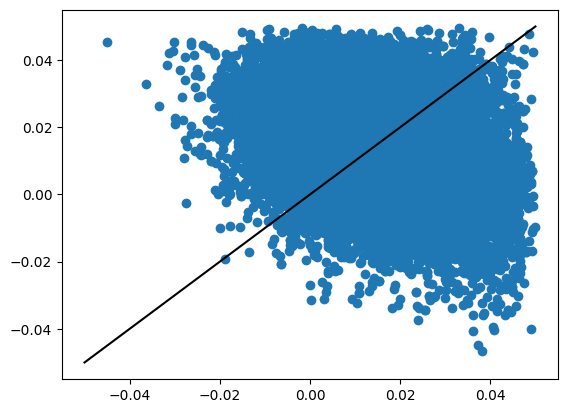

In [8]:
x = np.linspace(-0.05, 0.05, 200)
plt.scatter(s1z, s2z);
plt.plot(x,x, c='k')

In [51]:
#-- map_values of the samples --

params = ['m1_det', 'm2_det', 's1z', 's2z', 'ra', 'dec', 'dL', 'iota', 'psi']

samples = dict(m1_det=m1_det, m2_det=m2_det, s1z=s1z, s2z=s2z, ra=ra, dec=dec, dL=dL, iota=iota, psi=psi)

params_dict = {}

for p in params:
    
    kernel = gaussian_kde(samples[p])
    map_val = samples[p][np.argmax(kernel(samples[p]))]
    params_dict[p] = map_val


In [52]:
params_dict

{'m1_det': 1.7589816660001962,
 'm2_det': 1.6536107772146855,
 's1z': 0.0010755060045968203,
 's2z': 0.0019276643497063534,
 'ra': 4.337922984162745,
 'dec': -0.25485116424211895,
 'dL': 170.9952201099578,
 'iota': 0.583454803428515,
 'psi': 1.8441991077237665}

### $\Rightarrow$ Reference for Comoving Volume Priors: https://github.com/gwastro/4-ogc/blob/master/inference_configuration/inference-GW190425_081805.ini

$$V_{\text{com}} = [5e3, 4e8]$$

<br>

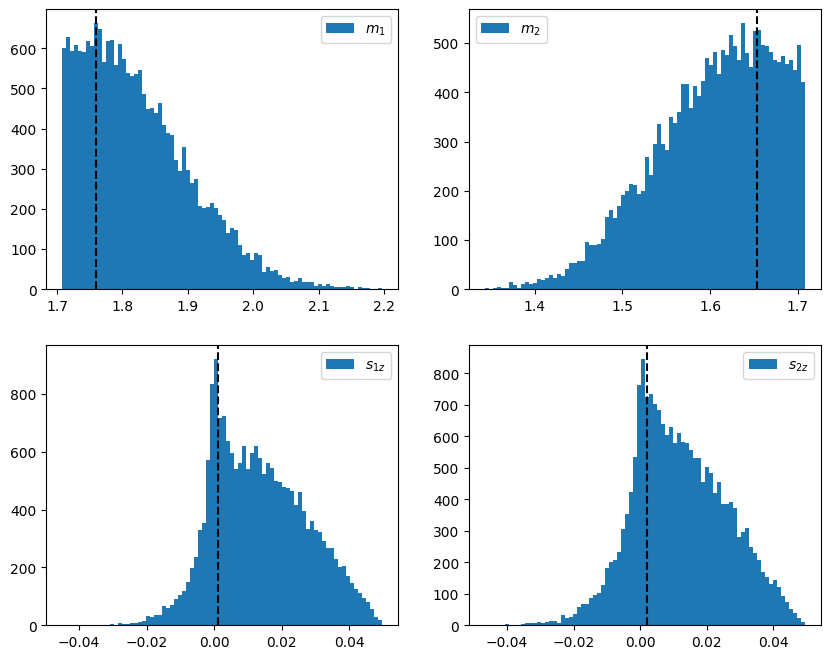

In [40]:
#-- plots --

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0,0].hist(m1_det, bins= 80, label = r'$m_1$')
ax[0, 0].axvline(x=params_dict['m1_det'], c='k', ls='--')
ax[0, 0].legend(loc="best")

ax[0,1].hist(m2_det, bins= 80, label = r'$m_2$')
ax[0, 1].axvline(x=params_dict['m2_det'], c='k', ls='--')
ax[0, 1].legend(loc="best")

ax[1,0].hist(s1z, bins= 80, label = r'$s_{1z}$')
ax[1, 0].axvline(x=params_dict['s1z'], c='k', ls='--')
ax[1, 0].legend(loc="best")

ax[1,1].hist(s2z, bins= 80, label = r'$s_{2z}$')
ax[1, 1].axvline(x=params_dict['s2z'], c='k', ls='--')
ax[1, 1].legend(loc="best")

plt.show()

<br>

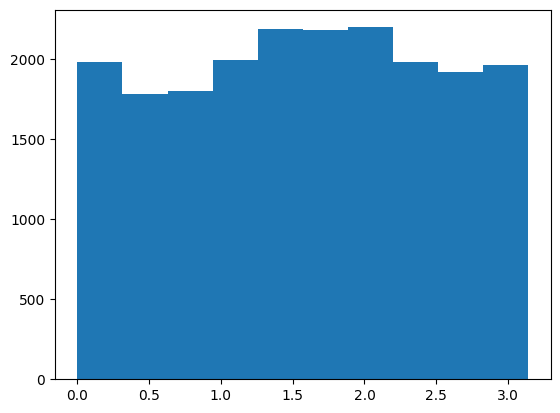

In [41]:
plt.hist(psi);

In [53]:
mc = post_samples['chirp_mass']

(array([  14.,   78.,  621., 2587., 5913., 6541., 3178.,  930.,  125.,
          13.]),
 array([1.48593795, 1.48610894, 1.48627993, 1.48645092, 1.4866219 ,
        1.48679289, 1.48696388, 1.48713487, 1.48730586, 1.48747685,
        1.48764784]),
 <BarContainer object of 10 artists>)

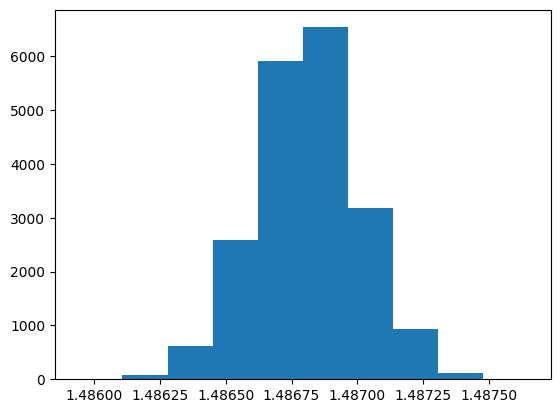

In [54]:
plt.hist(mc)